# Environment and set-up

In [ ]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import random
%matplotlib inline

BOARD_ROWS = 3
BOARD_COLS = 3


class State:
    def __init__(self, p1, p2):
        #create a board of any size
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        #player 1
        self.p1 = p1
        #player 2
        self.p2 = p2
        #is the game over
        self.isEnd = False
        #the has of the board state
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1

    # get unique hash of current board state
    def getHash(self):
        #get a string hash of the board state
        self.boardHash = str(self.board.reshape(BOARD_COLS * BOARD_ROWS))
        return self.boardHash

    #returns 1 if p1 won, -1 if p2 won
    def winner(self):
        # row
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS - i - 1] for i in range(BOARD_COLS)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == 3:
            self.isEnd = True
            if diag_sum1 == 3 or diag_sum2 == 3:
                return 1
            else:
                return -1

        # tie
        # no available positions
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None

    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions

    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    # only when game ends
    def giveReward(self):
        result = self.winner()
        # backpropagate reward
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)

    # board reset
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1
        
    # Random vs. Q-Agent (Training) Player 2 is the Q-learning agent and Player 2 goes first
    def play0(self, rounds=100):
        results = []
        for i in range(rounds):
            #if i % 1000 == 0:
                #print("Rounds {}".format(i))
            while not self.isEnd:
                    # Player 2 goes first
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.winner()
                    if win is not None:
                        if win == 0:
                            self.p2.feedReward(0)
                            self.p2.reset()
                            self.reset()
                            results.append(0)
                            break
                        # self.showBoard()
                        # ended with p2 either win or draw
                        results.append(-1)
                        self.p2.feedReward(1)
                        self.p2.reset()
                        self.reset()
                        break
                    else:
                     # Player 1
                     positions = self.availablePositions()
                     p1_action = self.p1.chooseAction(positions)
                     # take action and upate board state
                     self.updateState(p1_action)
        
                     # check board status if it is end
                     win = self.winner()
                     if win is not None:
                       if win == 0:
                         self.p2.feedReward(0)
                         self.p2.reset()
                         self.reset()
                         results.append(0)
                         break
                       # self.showBoard()
                       # ended with p1 either win or draw
                       results.append(1)
                       self.p2.feedReward(-1)
                       self.p2.reset()
                       self.reset()
                       break
      
        self.p2.savePolicy()
        return results
  
    #Q Agent v. Q Agent (Training)
    def play(self, rounds=100):
        results = []
        for i in range(rounds):
            if i % 1000 == 0:
                print("Rounds {}".format(i))
            while not self.isEnd:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                # check board status if it is end
                win = self.winner()
                if win is not None:
                    if win == 0:
                        self.giveReward()
                        self.p2.reset()
                        self.p1.reset()
                        self.reset()
                        results.append(0)
                        break
                    # self.showBoard()
                    # ended with p1 either win or draw
                    results.append(1)
                    self.giveReward()
                    self.p2.reset()
                    self.p1.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.winner()
                    if win is not None:
                        if win == 0:
                            self.giveReward()
                            self.p2.reset()
                            self.p1.reset()
                            self.reset()
                            results.append(0)
                            break
                        # self.showBoard()
                        # ended with p2 either win or draw
                        results.append(-1)
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break
        self.p1.savePolicy()
        self.p2.savePolicy()
        return results
  
    # Q-Agent vs. Random OR Human player (Have to specify with appropriate classes)
    def play2(self, showBoard = False):
        results = []
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateState(p1_action)
            if showBoard:
                self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    results.append(1)
                    if showBoard:
                        print(self.p1.name, "wins!")
                else:
                    results.append(0)
                    if showBoard:
                        print("tie!")
                self.reset()
                self.p1.reset()
                self.p2.reset()
                self.reset()               
                break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions)
                self.updateState(p2_action)
                if showBoard:
                    self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        results.append(-1)
                        if showBoard:
                            print(self.p2.name, "wins!")
                    else:
                        results.append(0)
                        if showBoard:
                            print("tie!")
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                    self.reset()
                    break
        return win

    # Human or Random vs. Human or Random (H v. H, R v. H, R v. R)
    def play3(self, showBoard = False):
        results = []
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions)
            # take action and upate board state
            self.updateState(p1_action)
            if showBoard:
                self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    results.append(1)
                    if showBoard:
                        print(self.p1.name, "wins!")
                else:
                    results.append(0)
                    if showBoard:
                        print("tie!")
                self.reset()
                break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions)
                self.updateState(p2_action)
                if showBoard:
                    self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        results.append(-1)
                        if showBoard:
                            print(self.p2.name, "wins!")
                    else:
                        results.append(0)
                        if showBoard:
                            print("tie!")
                    self.reset()
                    break
        return win
                    

    # Q vs Q (Both Trained)           
    def play4(self, showBoard = False):
        results = []
        self.reset()
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateState(p1_action)
            if showBoard:
                self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    results.append(1)
                    if showBoard:
                        print(self.p1.name, "wins!")
                        break
                else:
                    results.append(0)
                    if showBoard:
                        print("tie!")
                        break
                self.reset()
                break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p2_action)
                if showBoard:
                    self.showBoard()
                # check board status if it is end
                win = self.winner()
                if win is not None:
                    if win == -1:
                        results.append(-1)
                        if showBoard:
                            print(self.p2.name, "wins!")
                            break
                    else:
                        results.append(0)
                        if showBoard:
                            print("tie!")
                            break
                    self.reset()
                    break
        return win

    # Human or Random vs. Q Agent (First player advantage is important)
    def play5(self, showBoard = False):
        results = []
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions)
            # take action and upate board state
            self.updateState(p1_action)
            if showBoard:
                self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    results.append(1)
                    if showBoard:
                        print(self.p1.name, "wins!")
                else:
                    results.append(0)
                    if showBoard:
                        print("tie!")
                self.reset()
                break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p2_action)
                if showBoard:
                    self.showBoard()
                # check board status if it is end
                win = self.winner()
                if win is not None:
                    if win == -1:
                        results.append(-1)
                        if showBoard:
                            print(self.p2.name, "wins!")
                            break
                    else:
                        results.append(0)
                        if showBoard:
                            print("tie!")
                            break
                    self.reset()
                    break
        return win
        
    def play6(self, rounds=100, showBoard=False):
        results = []
        for i in range(rounds):
            if i % 1000 == 0:
                print("Rounds {}".format(i))
            while not self.isEnd:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p1_action)
                if showBoard:
                    self.showBoard()
                # check board status if it is end
                win = self.winner()
                if win is not None:
                    if win == 1:
                        results.append(1)
                        if showBoard:
                            print(self.p1.name, "wins!")
                            break
                    else:
                        results.append(0)
                        if showBoard:
                            print("tie!")
                            break
                    self.reset()
                    break
                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    # take action and upate board state
                    self.updateState(p2_action)
                    if showBoard:
                        self.showBoard()
                    # check board status if it is end
                    win = self.winner()
                    if win is not None:
                        if win == -1:
                            results.append(-1)
                            if showBoard:
                                print(self.p2.name, "wins!")
                                break
                        else:
                            results.append(0)
                            if showBoard:
                                print("tie!")
                                break
                        self.reset()
                        break
        return results


    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')
def createPlot(arr):
    plt.style.use('seaborn-darkgrid')
    labels, counts = np.unique(arr, return_counts=True)
    if len(labels) == 1:
        if labels[0] == 1:
            plt.bar(labels, counts, align='center')
            plt.gca().set_xticks(labels)
            plt.gca().set_xticklabels(['Player 1 wins'])
            plt.gca().set_ylabel('# of occurences')
            plt.show()
        if labels[0] == -1:
            plt.bar(labels, counts, align='center')
            plt.gca().set_xticks(labels)
            plt.gca().set_xticklabels(['Player 2 wins'])
            plt.gca().set_ylabel('# of occurences')
            plt.show()
        if labels[0] == 0:
            plt.bar(labels, counts, align='center')
            plt.gca().set_xticks(labels)
            plt.gca().set_xticklabels(['Tie'])
            plt.gca().set_ylabel('# of occurences')
            plt.show()
    else:
        plt.bar(labels, counts, align='center')
        plt.gca().set_xticks(labels)
        plt.gca().set_xticklabels(['Player 2 Wins', 'Ties', 'Player 1 wins'])
        plt.gca().set_ylabel('# of occurences')
        plt.show()

# Q-learning Player

In [ ]:
class qPlayer:
    def __init__(self, name, exp_rate=0.3, lr = 0.2, gamma = 0.9):
        self.name = name
        self.states = []
        self.lr = lr
        self.exp_rate = exp_rate
        self.decay_gamma = gamma
        self.states_value = {}
        #self.seed=0

    def getHash(self, board):
        boardHash = str(board.reshape(BOARD_COLS * BOARD_ROWS))
        return boardHash

    def chooseAction(self, positions, current_board, symbol):
        #np.random.seed(self.seed)
        if np.random.uniform(0, 1) <= self.exp_rate:
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                # print("value", value)
                if value >= value_max:
                    value_max = value
                    action = p
        return action

    def addState(self, state):
        self.states.append(state)

    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

    def reset(self):
        self.states = []
        
    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

# Human Player

In [ ]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name
  
    def chooseAction(self, allPositions): 
        while True:
            while True:
                try:
                    row = int(input(self.name + ", input row: "))
                    col = int(input(self.name + ", input col: "))
                except ValueError:
                    print("Sorry, I didn't understand that.")
                    quit = str(input(self.name + ", Type Q or q to quit, else just click enter again!")).lower()
                    if quit=='q':
                        quit()
                    continue
                else:
                    break
            action = (row-1, col-1);
            if action in allPositions:
                return action
            else:
              print("This position is not available. Please enter another.")

# Random Player

In [ ]:
class RandomPlayer(qPlayer):
    def __init__(self, name):
        self.name = name
        #self.seed=seed
  
    def chooseAction(self, allPositions,boardd=None,symbol=None): 
        #random action
        #numpy.random.seed(self.seed)
        index = np.random.choice(len(allPositions))
        action = allPositions[index]
        return action

# Training Process: Q-Learning vs. Q-Learning 

In [ ]:
p1 = qPlayer('p1')
p2 = qPlayer('p2')
game = State(p1, p2)
winners = game.play(10000)
createPlot(winners)

Rounds 0
Rounds 1000
Rounds 2000
Rounds 3000


### Training a Q-Agent vs a Random Agent

In [ ]:
p3 = qPlayer('p3')
p4 = RandomPlayer('Random')
game = State(p4, p3)
winners = game.play0(10000)
createPlot(winners)

# Epsilon Tuning: Finding the best epsilon

In [50]:
# Training Q-learning agents (with different epsilons) agianst random players (Q-learning player goes first)
epsilons=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
train_scores=[]
test_scores=[]

for epsilon in epsilons:
    name="p2_"+str(epsilon)

    # Training Against Random Player   
    p1 = RandomPlayer("Random")
    p2 = qPlayer(name,exp_rate=epsilon)
    game = State(p1, p2)
    winners=game.play0(1000)
    train_score=-np.sum(winners)
    train_scores.append(train_score)

    # Testing Against P2, a previously-trained Q-agent
    p1 = qPlayer(name, exp_rate=0)
    p1.loadPolicy("policy_"+name)
    p2 = qPlayer("p2")
    p2.loadPolicy("policy_p2")
    game = State(p1, p2)
    test_score=0
    for x in range(1000):
        game.reset()
        test_score=test_score+game.play4(False)
    test_scores.append(test_score)


In [51]:
# The scores equal to the number of wins minus the number of loses
print(train_scores) 
print(len(train_scores))
print(test_scores)
print(len(test_scores))

[848, 723, 645, 613, 504, 499, 407, 371, 385, 334, 279]
11
[853, 878, 826, -75, 439, 869, 38, -214, 347, -17, -49]
11


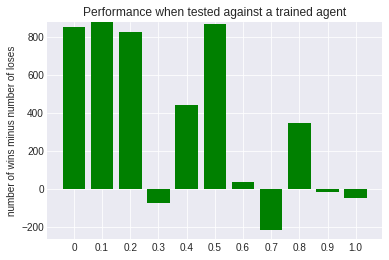

In [52]:
x = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0']
data = test_scores
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, data, color='green')
plt.title("Performance when tested against a trained agent")
plt.ylabel("number of wins minus number of loses")
plt.xticks(x_pos, x)
plt.gca().set_ylim([np.min(test_scores)-50,np.max(test_scores)])
plt.show()

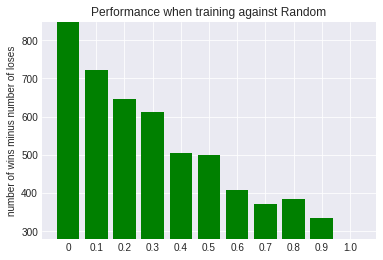

In [53]:
data = train_scores
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, data, color='green')
plt.title("Performance when training against Random")
plt.ylabel("number of wins minus number of loses")
plt.xticks(x_pos, x)
plt.gca().set_ylim([np.min(train_scores),np.max(train_scores)])
plt.show()
plt.show()


# Random Vs. Random 10000 rounds

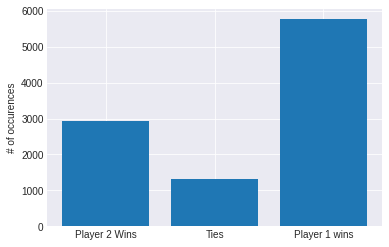

In [54]:
winners = []
p1 = RandomPlayer('X')
p2 = RandomPlayer('O')
game = State(p1, p2)
for i in range(10000):
    game.reset()
    winners.append(game.play3(False))
createPlot(winners)

Trained Q Agent vs Random
(Order is extremely important, as seen in the code after this block)

# Trained Q Agent vs Random, Q-learning Goes First
(Order is extremely important, as seen in the code after this block)

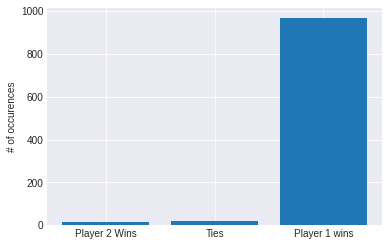

In [55]:
p1 = qPlayer('Q-Agent', exp_rate=0)
winners = []
p2 = RandomPlayer('Random')
p1.loadPolicy("policy_p1")
game = State(p1, p2)
for x in range(1000):
    game.reset()
    winners.append(game.play2(False))
createPlot(winners)

# Trained Q Agent vs. Random, Random Goes First

With the wrong policy

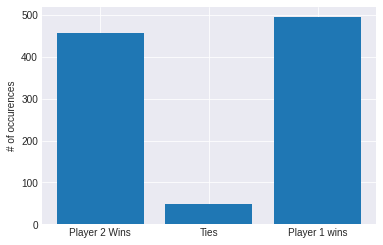

In [56]:
p2 = qPlayer('Q-Agent', exp_rate=0)
winners = []
p1 = RandomPlayer('Random')
p2.loadPolicy("policy_p1")
game = State(p1, p2)
for x in range(1000):
    game.reset()
    winners.append(game.play5(False))
createPlot(winners)

With the right policy

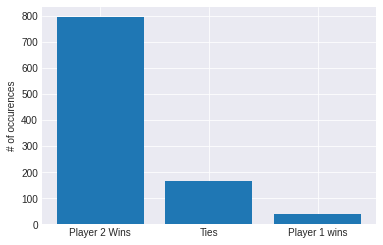

In [57]:
p2 = qPlayer('Q-Agent', exp_rate=0)
winners = []
p1 = RandomPlayer('Random')
p2.loadPolicy("policy_p2")
game = State(p1, p2)
for x in range(1000):
    game.reset()
    winners.append(game.play5(False))
createPlot(winners)

# Trained Q-learning playing against itself

Rounds 0


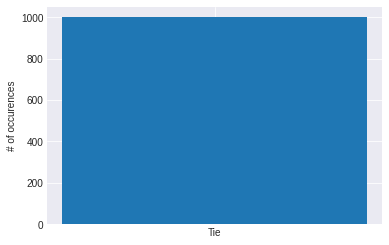

In [58]:
p1 = qPlayer('Q-Agent', exp_rate=0)
p2 = qPlayer('Q-Agent', exp_rate=0)
p1.loadPolicy("policy_p1")
p2.loadPolicy("policy_p2")
game = State(p1, p2)
winners = game.play6(1000)
createPlot(winners)

# Human v. Human (Play if you'd like!)

In [ ]:
p1 = HumanPlayer('x')
p2 = HumanPlayer('o')
game = State(p1, p2)
game.play3(True)

### Human vs Q-Agent test 

Q-Agent 1st, correct Q-policy

In [ ]:
p1 = qPlayer('Q-Agent', exp_rate=0)
p2 = HumanPlayer('Human')
p1.loadPolicy("policy_p1")
game = State(p1, p2)
game.play2(True)

# I just change the starting index of column and row to 1 instead of 0
# This means that row 2 means the second row (not the third row))

-------------
|   |   | x | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------


KeyboardInterrupt: ignored

Q-Agent 1st, incorrect policy

In [ ]:
p1 = qPlayer('Q-Agent', exp_rate=0)
p2 = HumanPlayer('Human')
p1.loadPolicy("policy_p2")
game = State(p1, p2)
game.play2(True)

# I just change the starting index of column and row to 1 instead of 0
# This means that row 2 means the second row (not the third row))

-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   | x | 
-------------
Human, input row: 1
Human, input col: 1
-------------
| o |   |   | 
-------------
|   |   |   | 
-------------
|   |   | x | 
-------------
-------------
| o |   |   | 
-------------
|   |   |   | 
-------------
|   | x | x | 
-------------
Human, input row: 1
Human, input col: 2
-------------
| o | o |   | 
-------------
|   |   |   | 
-------------
|   | x | x | 
-------------
-------------
| o | o |   | 
-------------
|   |   |   | 
-------------
| x | x | x | 
-------------
Q-Agent wins!


AttributeError: ignored

Human 1st, correct policy

In [ ]:
p2 = qPlayer('Q-Agent', exp_rate=0)
p1 = HumanPlayer('Human')
p2.loadPolicy("policy_p2")
game = State(p1, p2)
game.play5(True)

# I just change the starting index of column and row to 1 instead of 0
# This means that row 2 means the second row (not the third row))

Human, input row: 1
Human, input col: 2
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
-------------
|   | x | o | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
Human, input row: 2
Human, input col: 2
-------------
|   | x | o | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
-------------
|   | x | o | 
-------------
|   | x |   | 
-------------
|   | o |   | 
-------------
Human, input row: 3
Human, input col: 3
-------------
|   | x | o | 
-------------
|   | x |   | 
-------------
|   | o | x | 
-------------
-------------
| o | x | o | 
-------------
|   | x |   | 
-------------
|   | o | x | 
-------------
Human, input row: 3
Human, input col: 1
-------------
| o | x | o | 
-------------
|   | x |   | 
-------------
| x | o | x | 
-------------
-------------
| o | x | o | 
-------------
|   | x | o | 
-------------
| x | o | x | 
-------------
Human, input row: 2
Human, input

0

Human 1st, incorrect Q policy

In [ ]:
p2 = qPlayer('Q-Agent', exp_rate=0)
p1 = HumanPlayer('Human')
p2.loadPolicy("policy_p1")
game = State(p1, p2)
game.play5(True)

# I just change the starting index of column and row to 1 instead of 0
# This means that row 2 means the second row (not the third row))

Human, input row: 2
Human, input col: 2
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
-------------
|   |   |   | 
-------------
|   | x |   | 
-------------
|   |   | o | 
-------------
Human, input row: 2
Human, input col: 1
-------------
|   |   |   | 
-------------
| x | x |   | 
-------------
|   |   | o | 
-------------
-------------
|   |   |   | 
-------------
| x | x |   | 
-------------
|   | o | o | 
-------------
Human, input row: 2
Human, input col: 3
-------------
|   |   |   | 
-------------
| x | x | x | 
-------------
|   | o | o | 
-------------
Human wins!


1

# Human vs. Random

In [ ]:
p1 = HumanPlayer('x')
p2 = RandomPlayer('o')
game = State(p1, p2)
game.play3(True)